In [ ]:
# default_exp data.preparation

# Data preparation

> Functions required to prepare X (and y) from a pandas dataframe.

In [ ]:
# export
from tsai.imports import *
from tsai.utils import *
from tsai.data.validation import *

In [ ]:
#export
def df2Xy(df, sample_col=None, feat_col=None, data_cols=None, target_col=None, to3d=True, splits=None, sort_by=None, ascending=True, y_func=None):
    r"""
    This function allows you to transform a pandas dataframe into X and y numpy arrays that can be used to craete a TSDataset.
    sample_col: column that uniquely identifies each sample.
    feat_col: used for multivariate datasets. It indicates which is the column that indicates the feature by row.
    data_col: indicates ths column/s where the data is located. If None, it means all columns (except the sample_col, feat_col, and target_col)
    target_col: indicates the column/s where the target is.
    to3d: turns X to 3d (including univariate time series)
    sort_by: used to indicate how to sort the dataframe.
    y_func: function used to calculate y for each sample (and target_col)
    """
    if feat_col is not None:
        assert sample_col is not None, 'You must pass a sample_col when you pass a feat_col'

    passed_cols = []
    sort_cols = []
    if sort_by is not None:
        if isinstance(sort_by, pd.core.indexes.base.Index): sort_by = sort_by.tolist()
        sort_cols += listify(sort_by)
    if sample_col is not None:
        if isinstance(sample_col, pd.core.indexes.base.Index): sample_col = sample_col.tolist()
        sample_col = listify(sample_col)
        sort_cols += listify(sample_col)
        passed_cols += sample_col
    if feat_col is not None:
        if isinstance(feat_col, pd.core.indexes.base.Index): feat_col = feat_col.tolist()
        feat_col = listify(feat_col)
        sort_cols += listify(feat_col)
        passed_cols += feat_col
    if data_cols is not None:
        if isinstance(data_cols, pd.core.indexes.base.Index): data_cols = data_cols.tolist()
        data_cols = listify(data_cols)
    if target_col is not None:
        if isinstance(target_col, pd.core.indexes.base.Index): target_col = target_col.tolist()
        target_col = listify(target_col)
        passed_cols += target_col

    if data_cols is None:
        data_cols = [col for col in df.columns if col not in passed_cols]
    if sort_cols:
        df.sort_values(sort_cols, ascending=ascending, inplace=True)

    # X
    X = df.loc[:, data_cols].values
    if X.dtype == 'O':
        X = X.astype(np.float32)
    if sample_col is not None:
        unique_ids = df[sample_col[0]].unique().tolist()
        n_samples = len(unique_ids)
    else:
        unique_ids = np.arange(len(df)).tolist()
        n_samples = len(df)
    if feat_col is not None:
        n_feats = df[feat_col[0]].nunique()
        X = X.reshape(n_samples, n_feats, -1)
    elif to3d:
        X = X.reshape(n_samples, 1, -1)

    # y
    if target_col is not None:
        if sample_col is not None: 
            y = []
            for tc in target_col:
                _y = np.concatenate(df.groupby(sample_col)[tc].apply(np.array).reset_index()[tc]).reshape(n_samples, -1)
                if y_func is not None: _y = y_func(_y)
                y.append(_y)
            y = np.concatenate(y, -1)
        else: 
            y = df[target_col].values
        y = np.squeeze(y)
    else:
        y = None

    # Output
    if splits is None: return X, y
    else: return split_xy(X, y, splits)
    

def split_Xy(X, y=None, splits=None):
    if splits is None: 
        if y is not None: return X, y
        else: return X
    if not is_listy(splits[0]): splits = [splits]
    else: assert not is_listy(splits[0][0]), 'You must pass a single set of splits.'
    _X = []
    _y = []
    for split in splits:
        _X.append(X[split])
        if y is not None: _y.append(y[split])
    if len(splits) == 1: return _X[0], _y[0]
    elif len(splits) == 2: return _X[0], _y[0], _X[1], _y[1]
    elif len(splits) == 3: return _X[0], _y[0], _X[1], _y[1], _X[2], _y[2]
    
df2xy = df2Xy
split_xy = split_Xy

In [ ]:
n_samples = 1_000
n_rows = 10_000

sample_ids = np.arange(n_samples).repeat(n_rows//n_samples).reshape(-1,1)
feat_ids = np.tile(np.arange(n_rows // n_samples), n_samples).reshape(-1,1)
cont = np.random.randn(n_rows, 6)
ind_cat = np.random.randint(0, 3, (n_rows, 1))
target = np.array(['a', 'b', 'c'])[ind_cat]
ind_cat2 = np.random.randint(0, 3, (n_rows, 1))
target2 = np.array(['a', 'b', 'c'])[ind_cat2]
data = np.concatenate([sample_ids, feat_ids, cont, target, target], -1)
columns = ['sample_id', 'feat_id'] + (np.arange(6) + 1).astype(str).tolist() + ['target'] + ['target2']
df = pd.DataFrame(data, columns=columns)
idx = np.random.choice(np.arange(len(df)), len(df), False)
new_dtypes = {'sample_id':np.int32, 'feat_id':np.int32, '1':np.float32, '2':np.float32, '3':np.float32, '4':np.float32, '5':np.float32, '6':np.float32}
df = df.astype(dtype=new_dtypes)
df = df.loc[idx].reset_index(drop=True)
df

sample_id  feat_id         1         2         3         4         5  \
0           777        1 -1.080315  1.641942  0.733985 -0.996976 -1.121065   
1           487        9  0.518391  1.971519  0.111266  0.340936  0.311448   
2           937        4  1.103889 -0.178002 -0.772531  1.345002  0.313867   
3           608        7  0.520081  1.302805  1.894748  0.863586 -0.473113   
4           266        5 -1.049226  0.241023  1.419523 -0.294602  1.343877   
...         ...      ...       ...       ...       ...       ...       ...   
9995        875        3 -0.350996  1.666378  0.942827 -0.427752  0.067125   
9996        572        2 -0.355047  0.213517  0.919942  2.591823  0.397598   
9997        422        9 -1.032634  0.417853 -1.568932 -1.365495 -0.094820   
9998        551        8  0.490705 -0.027619  0.855900 -0.688120  0.067956   
9999        661        2 -1.451950  1.701566 -1.216624 -0.136940  0.256252   

             6 target target2  
0     0.235836      c       c  
1     1.442769      c       c  
2     0.290209      c       c  
3    -0.795739      b       b  
4     1.107058      b       b  
...        ...    ...     ...  
9995  1.432174      a       a  
9996 -1.369792      c       c  
9997 -0.119853      c       c  
9998  0.392449      a       a  
9999  1.250916      c       c  

[10000 rows x 10 columns]

In [ ]:
def y_func(o): return scipy.stats.mode(o, axis=1).mode
X, y = df2xy(df, sample_col='sample_id', feat_col='feat_id', data_cols=['1', '2', '3', '4', '5', '6'], target_col=['target'], y_func=y_func)
test_eq(X.shape, (1000, 10, 6))
test_eq(y.shape, (1000,))
rand_idx = np.random.randint(0, np.max(df.sample_id))
sorted_df = df.sort_values(by=['sample_id', 'feat_id']).reset_index(drop=True)
test_eq(X[rand_idx], sorted_df[sorted_df.sample_id == rand_idx][['1', '2', '3', '4', '5', '6']].values)
test_eq(np.squeeze(scipy.stats.mode(sorted_df[sorted_df.sample_id == rand_idx][['target']].values).mode), y[rand_idx])

In [ ]:
def y_func(o): return scipy.stats.mode(o, axis=1).mode
X, y = df2xy(df, sample_col='sample_id', feat_col='feat_id', target_col=['target', 'target2'], y_func=y_func)
test_eq(X.shape, (1000, 10, 6))
test_eq(y.shape, (1000, 2))
rand_idx = np.random.randint(0, np.max(df.sample_id))
sorted_df = df.sort_values(by=['sample_id', 'feat_id']).reset_index(drop=True)
test_eq(X[rand_idx], sorted_df[sorted_df.sample_id == rand_idx][['1', '2', '3', '4', '5', '6']].values)
test_eq(np.squeeze(scipy.stats.mode(sorted_df[sorted_df.sample_id == rand_idx][['target', 'target2']].values).mode), y[rand_idx])

In [ ]:
# Univariate
from io import StringIO
TESTDATA = StringIO("""sample_id;value_0;value_1;target
    rob;2;3;hot
    alice;6;7;lukewarm
    eve;11;12;cold
    """)

df = pd.read_csv(TESTDATA, sep=";")
display(df)
X, y = df2Xy(df, sample_col='sample_id', target_col='target', data_cols=['value_0', 'value_1'], sort_by='sample_id')
test_eq(X.shape, (3, 1, 2))
test_eq(y.shape, (3,))
X, y

sample_id  value_0  value_1    target
0        rob        2        3       hot
1      alice        6        7  lukewarm
2        eve       11       12      cold

(array([[[ 6,  7]],
 
        [[11, 12]],
 
        [[ 2,  3]]]),
 array(['lukewarm', 'cold', 'hot'], dtype=object))

In [ ]:
# Univariate
TESTDATA = StringIO("""sample_id;timestep;values;target
    rob;1;2;hot
    alice;1;6;lukewarm
    eve;1;11;cold
    
    rob;2;3;hot
    alice;2;7;lukewarm
    eve;2;12;cold
    """)

df = pd.read_csv(TESTDATA, sep=";")
display(df)
def y_func(o): return scipy.stats.mode(o, axis=1).mode
X, y = df2xy(df, sample_col='sample_id', target_col='target', data_cols=['values'], sort_by='timestep', to3d=True, y_func=y_func)
test_eq(X.shape, (3, 1, 2))
test_eq(y.shape, (3, ))
print(X, y)

sample_id  timestep  values    target
0        rob         1       2       hot
1      alice         1       6  lukewarm
2        eve         1      11      cold
3        rob         2       3       hot
4      alice         2       7  lukewarm
5        eve         2      12      cold

[[[ 6 11]]

 [[ 2  7]]

 [[12  3]]] ['lukewarm' 'cold' 'hot']


In [ ]:
# Multivariate
TESTDATA = StringIO("""sample_id;trait;value_0;value_1;target
    rob;green;2;3;hot
    rob;yellow;3;4;hot
    rob;blue;4;5;hot
    rob;red;5;6;hot
    alice;green;6;7;lukewarm
    alice;yellow;7;8;lukewarm
    alice;blue;8;9;lukewarm
    alice;red;9;10;lukewarm
    eve;yellow;11;12;cold
    eve;green;10;11;cold
    eve;blue;12;12;cold
    eve;red;13;14;cold
    """)

df = pd.read_csv(TESTDATA, sep=";")
idx = np.random.choice(len(df), len(df), False)
df = df.iloc[idx]
display(df)
def y_func(o): return scipy.stats.mode(o, axis=1).mode
X, y = df2xy(df, sample_col='sample_id', feat_col='trait', target_col='target', data_cols=['value_0', 'value_1'], y_func=y_func)
print(X, y)
test_eq(X.shape, (3, 4, 2))
test_eq(y.shape, (3,))

sample_id   trait  value_0  value_1    target
10        eve    blue       12       12      cold
3         rob     red        5        6       hot
1         rob  yellow        3        4       hot
2         rob    blue        4        5       hot
7       alice     red        9       10  lukewarm
6       alice    blue        8        9  lukewarm
8         eve  yellow       11       12      cold
11        eve     red       13       14      cold
0         rob   green        2        3       hot
5       alice  yellow        7        8  lukewarm
4       alice   green        6        7  lukewarm
9         eve   green       10       11      cold

[[[ 8  9]
  [ 6  7]
  [ 9 10]
  [ 7  8]]

 [[12 12]
  [10 11]
  [13 14]
  [11 12]]

 [[ 4  5]
  [ 2  3]
  [ 5  6]
  [ 3  4]]] ['lukewarm' 'cold' 'hot']


In [ ]:
# Multivariate, multi-label
TESTDATA = StringIO("""sample_id;trait;value_0;value_1;target1;target2
    rob;green;2;3;hot;good
    rob;yellow;3;4;hot;good
    rob;blue;4;5;hot;good
    rob;red;5;6;hot;good
    alice;green;6;7;lukewarm;good
    alice;yellow;7;8;lukewarm;good
    alice;blue;8;9;lukewarm;good
    alice;red;9;10;lukewarm;good
    eve;yellow;11;12;cold;bad
    eve;green;10;11;cold;bad
    eve;blue;12;12;cold;bad
    eve;red;13;14;cold;bad
    """)

df = pd.read_csv(TESTDATA, sep=";")
display(df)
def y_func(o): return scipy.stats.mode(o, axis=1).mode
X, y = df2xy(df, sample_col='sample_id', feat_col='trait', target_col=['target1', 'target2'], data_cols=['value_0', 'value_1'], y_func=y_func)
test_eq(X.shape, (3, 4, 2))
test_eq(y.shape, (3, 2))
print(X, y)

sample_id   trait  value_0  value_1   target1 target2
0         rob   green        2        3       hot    good
1         rob  yellow        3        4       hot    good
2         rob    blue        4        5       hot    good
3         rob     red        5        6       hot    good
4       alice   green        6        7  lukewarm    good
5       alice  yellow        7        8  lukewarm    good
6       alice    blue        8        9  lukewarm    good
7       alice     red        9       10  lukewarm    good
8         eve  yellow       11       12      cold     bad
9         eve   green       10       11      cold     bad
10        eve    blue       12       12      cold     bad
11        eve     red       13       14      cold     bad

[[[ 8  9]
  [ 6  7]
  [ 9 10]
  [ 7  8]]

 [[12 12]
  [10 11]
  [13 14]
  [11 12]]

 [[ 4  5]
  [ 2  3]
  [ 5  6]
  [ 3  4]]] [['lukewarm' 'good']
 ['cold' 'bad']
 ['hot' 'good']]


In [ ]:
# Multivariate, unlabeled
TESTDATA = StringIO("""sample_id;trait;value_0;value_1;target
    rob;green;2;3;hot
    rob;yellow;3;4;hot
    rob;blue;4;5;hot
    rob;red;5;6;hot
    alice;green;6;7;lukewarm
    alice;yellow;7;8;lukewarm
    alice;blue;8;9;lukewarm
    alice;red;9;10;lukewarm
    eve;yellow;11;12;cold
    eve;green;10;11;cold
    eve;blue;12;12;cold
    eve;red;13;14;cold
    """)

df = pd.read_csv(TESTDATA, sep=";")
idx = np.random.choice(len(df), len(df), False)
df = df.iloc[idx]
display(df)
def y_func(o): return scipy.stats.mode(o, axis=1).mode
X, y = df2xy(df, sample_col='sample_id', feat_col='trait', data_cols=['value_0', 'value_1'], y_func=y_func)
print(X, y)
test_eq(X.shape, (3, 4, 2))
test_eq(y, None)

sample_id   trait  value_0  value_1    target
4       alice   green        6        7  lukewarm
9         eve   green       10       11      cold
10        eve    blue       12       12      cold
11        eve     red       13       14      cold
0         rob   green        2        3       hot
8         eve  yellow       11       12      cold
3         rob     red        5        6       hot
6       alice    blue        8        9  lukewarm
2         rob    blue        4        5       hot
1         rob  yellow        3        4       hot
5       alice  yellow        7        8  lukewarm
7       alice     red        9       10  lukewarm

[[[ 8  9]
  [ 6  7]
  [ 9 10]
  [ 7  8]]

 [[12 12]
  [10 11]
  [13 14]
  [11 12]]

 [[ 4  5]
  [ 2  3]
  [ 5  6]
  [ 3  4]]] None


In [ ]:
TESTDATA = StringIO("""sample_id;trait;timestep;values;target
    rob;green;1;2;hot
    rob;yellow;1;3;hot
    rob;blue;1;4;hot
    rob;red;1;5;hot
    alice;green;1;6;lukewarm
    alice;yellow;1;7;lukewarm
    alice;blue;1;8;lukewarm
    alice;red;1;9;lukewarm
    eve;yellow;1;11;cold
    eve;green;1;10;cold
    eve;blue;1;12;cold
    eve;red;1;13;cold
    
    rob;green;2;3;hot
    rob;yellow;2;4;hot
    rob;blue;2;5;hot
    rob;red;2;6;hot
    alice;green;2;7;lukewarm
    alice;yellow;2;8;lukewarm
    alice;blue;2;9;lukewarm
    alice;red;2;10;lukewarm
    eve;yellow;2;12;cold
    eve;green;2;11;cold
    eve;blue;2;13;cold
    eve;red;2;14;cold
    """)

df = pd.read_csv(TESTDATA, sep=";")
display(df)
def y_func(o): return scipy.stats.mode(o, axis=1).mode
X, y = df2xy(df, sample_col='sample_id', feat_col='trait', sort_by='timestep', target_col='target', data_cols=['values'], y_func=y_func)
print(X, y)
test_eq(X.shape, (3, 4, 2))
test_eq(y.shape, (3, ))

sample_id   trait  timestep  values    target
0         rob   green         1       2       hot
1         rob  yellow         1       3       hot
2         rob    blue         1       4       hot
3         rob     red         1       5       hot
4       alice   green         1       6  lukewarm
5       alice  yellow         1       7  lukewarm
6       alice    blue         1       8  lukewarm
7       alice     red         1       9  lukewarm
8         eve  yellow         1      11      cold
9         eve   green         1      10      cold
10        eve    blue         1      12      cold
11        eve     red         1      13      cold
12        rob   green         2       3       hot
13        rob  yellow         2       4       hot
14        rob    blue         2       5       hot
15        rob     red         2       6       hot
16      alice   green         2       7  lukewarm
17      alice  yellow         2       8  lukewarm
18      alice    blue         2       9  lukewarm
19      alice     red         2      10  lukewarm
20        eve  yellow         2      12      cold
21        eve   green         2      11      cold
22        eve    blue         2      13      cold
23        eve     red         2      14      cold

[[[ 8  6]
  [ 9  7]
  [12 10]
  [13 11]]

 [[ 4  2]
  [ 5  3]
  [ 9  7]
  [10  8]]

 [[13 11]
  [14 12]
  [ 5  3]
  [ 6  4]]] ['lukewarm' 'cold' 'hot']


In [ ]:
# export
def df2np3d(df, groupby, data_cols=None):
    """Transforms a df (with the same number of rows per group in groupby) to a 3d ndarray"""
    if data_cols is None: data_cols = df.columns
    return np.stack([x[data_cols].values for _, x in df.groupby(groupby)]).transpose(0, 2, 1)

In [ ]:
user = np.array([1,2]).repeat(4).reshape(-1,1)
val = np.random.rand(8, 3)
data = np.concatenate([user, val], axis=-1)
df = pd.DataFrame(data, columns=['user', 'x1', 'x2', 'x3'])
test_eq(df2np3d(df, ['user'], ['x1', 'x2', 'x3']).shape, (2, 3, 4))

In [ ]:
# export
def add_missing_value_cols(df, cols=None, dtype=float):
    if cols is None: cols = df.columns
    elif not is_listy(cols): cols = [cols]
    for col in cols:
        df[f'missing_{col}'] = df[col].isnull().astype(dtype)
    return df

In [ ]:
data = np.random.randn(10, 2)
mask = data > .8
data[mask] = np.nan
df = pd.DataFrame(data, columns=['A', 'B'])
df = add_missing_value_cols(df, cols=None, dtype=float)
test_eq(df['A'].isnull().sum(), df['missing_A'].sum())
test_eq(df['B'].isnull().sum(), df['missing_B'].sum())
df

A         B  missing_A  missing_B
0       NaN -1.405983        1.0        0.0
1 -1.521326  0.283531        0.0        0.0
2  0.205859 -0.988792        0.0        0.0
3 -0.259695 -0.404819        0.0        0.0
4       NaN -0.014230        1.0        0.0
5 -0.874974  0.299489        0.0        0.0
6       NaN  0.266791        1.0        0.0
7  0.562328 -0.787693        0.0        0.0
8 -0.561105       NaN        0.0        1.0
9       NaN -2.462756        1.0        0.0

In [ ]:
# export

def add_missing_timestamps(df, datetime_col, groupby=None, fill_value=np.nan, range_by_group=True, freq=None):
    """Fills missing timestamps in a dataframe to a desired frequency
    Args:
        df:                      pandas DataFrame
        datetime_col:            column that contains the datetime data (without duplicates within groups)
        groupby:                 column used to identify unique_ids
        fill_value:              values that will be insert where missing dates exist. Default:np.nan
        range_by_group:          if True, dates will be filled between min and max dates for each group. Otherwise, between the min and max dates in the df.
        freq:                    frequence used to fillin the missing datetime
    """
    if is_listy(datetime_col): 
        assert len(datetime_col) == 1, 'you can only pass a single datetime_col'
        datetime_col = datetime_col[0]
    dates = pd.date_range(df[datetime_col].min(), df[datetime_col].max(), freq=freq)
    if groupby is not None:
        if is_listy(groupby): 
            assert len(groupby) == 1, 'you can only pass a single groupby'
            groupby = groupby[0]
        keys = df[groupby].unique()
        if range_by_group:
            # Fills missing dates between min and max for each unique id
            min_dates = df.groupby(groupby)[datetime_col].min()
            max_dates = df.groupby(groupby)[datetime_col].max()
            idx_tuples = flatten_list([[(d, key) for d in pd.date_range(min_date, max_date, freq=freq)] for min_date, max_date, key in \
                                       zip(min_dates, max_dates, keys)])
            multi_idx = pd.MultiIndex.from_tuples(idx_tuples, names=[datetime_col, groupby])
            df = df.set_index([datetime_col, groupby]).reindex(multi_idx, fill_value=np.nan).reset_index()
        else:
            # Fills missing dates between min and max - same for all unique ids
            multi_idx = pd.MultiIndex.from_product((dates, keys), names=[datetime_col, groupby])
            df = df.set_index([datetime_col, groupby]).reindex(multi_idx, fill_value=np.nan)
            df = df.reset_index().sort_values(by=[groupby, datetime_col]).reset_index(drop=True)
    else: 
        index = pd.Index(dates, name=datetime_col)
        df = df.set_index([datetime_col]).reindex(index, fill_value=fill_value)
        df = df.reset_index().reset_index(drop=True)
    return df

In [ ]:
# Filling dates between min and max dates
dates = pd.date_range('2021-05-01', '2021-05-07').values
data = np.zeros((len(dates), 3))
data[:, 0] = dates
data[:, 1] = np.random.rand(len(dates))
data[:, 2] = np.random.rand(len(dates))
cols = ['date', 'feature1', 'feature2']
date_df = pd.DataFrame(data, columns=cols).astype({'date': 'datetime64[ns]', 'feature1': float, 'feature2': float})
date_df_with_missing_dates = date_df.drop([1,3]).reset_index(drop=True)
date_df_with_missing_dates

date  feature1  feature2
0 2021-05-01  0.898528  0.072979
1 2021-05-03  0.937873  0.594493
2 2021-05-05  0.467495  0.718770
3 2021-05-06  0.057948  0.558890
4 2021-05-07  0.868186  0.508611

In [ ]:
# No groups
expected_output_df = date_df.copy()
expected_output_df.loc[[1,3], ['feature1', 'feature2']] = np.nan
display(expected_output_df)
output_df = add_missing_timestamps(date_df_with_missing_dates, 
                                   'date', 
                                   groupby=None, 
                                   fill_value=np.nan, 
                                   range_by_group=False)
test_eq(output_df, expected_output_df)

date  feature1  feature2
0 2021-05-01  0.898528  0.072979
1 2021-05-02       NaN       NaN
2 2021-05-03  0.937873  0.594493
3 2021-05-04       NaN       NaN
4 2021-05-05  0.467495  0.718770
5 2021-05-06  0.057948  0.558890
6 2021-05-07  0.868186  0.508611

In [ ]:
# Filling dates between min and max dates for each value in groupby column
dates = pd.date_range('2021-05-01', '2021-05-07').values
dates = np.concatenate((dates, dates))
data = np.zeros((len(dates), 4))
data[:, 0] = dates
data[:, 1] = np.array([0]*(len(dates)//2)+[1]*(len(dates)//2))
data[:, 2] = np.random.rand(len(dates))
data[:, 3] = np.random.rand(len(dates))
cols = ['date', 'id', 'feature1', 'feature2']
date_df = pd.DataFrame(data, columns=cols).astype({'date': 'datetime64[ns]', 'id': int, 'feature1': float, 'feature2': float})
date_df_with_missing_dates = date_df.drop([0,1,3,8,11,13]).reset_index(drop=True)

date_df_with_missing_dates

date  id  feature1  feature2
0 2021-05-03   0  0.535052  0.569485
1 2021-05-05   0  0.606214  0.113467
2 2021-05-06   0  0.175161  0.889447
3 2021-05-07   0  0.290729  0.622261
4 2021-05-01   1  0.114906  0.505910
5 2021-05-03   1  0.460233  0.053664
6 2021-05-04   1  0.702913  0.206250
7 2021-05-06   1  0.761390  0.627249

In [ ]:
# groupby='id', range_by_group=True
expected_output_df = date_df.drop([0,1,13]).reset_index(drop=True)  
expected_output_df.loc[[1,6,9], ['feature1', 'feature2']] = np.nan
display(expected_output_df)
output_df = add_missing_timestamps(date_df_with_missing_dates, 
                                   'date', 
                                   groupby='id', 
                                   fill_value=np.nan, 
                                   range_by_group=True)
test_eq(expected_output_df, output_df)

date  id  feature1  feature2
0  2021-05-03   0  0.535052  0.569485
1  2021-05-04   0       NaN       NaN
2  2021-05-05   0  0.606214  0.113467
3  2021-05-06   0  0.175161  0.889447
4  2021-05-07   0  0.290729  0.622261
5  2021-05-01   1  0.114906  0.505910
6  2021-05-02   1       NaN       NaN
7  2021-05-03   1  0.460233  0.053664
8  2021-05-04   1  0.702913  0.206250
9  2021-05-05   1       NaN       NaN
10 2021-05-06   1  0.761390  0.627249

In [ ]:
# groupby='id', range_by_group=False
expected_output_df = date_df.copy() 
expected_output_df.loc[[0,1,3,8,11,13], ['feature1', 'feature2']] = np.nan
display(expected_output_df)
output_df = add_missing_timestamps(date_df_with_missing_dates, 
                                   'date', 
                                   groupby='id', 
                                   fill_value=np.nan, 
                                   range_by_group=False)
test_eq(expected_output_df, output_df)

date  id  feature1  feature2
0  2021-05-01   0       NaN       NaN
1  2021-05-02   0       NaN       NaN
2  2021-05-03   0  0.535052  0.569485
3  2021-05-04   0       NaN       NaN
4  2021-05-05   0  0.606214  0.113467
5  2021-05-06   0  0.175161  0.889447
6  2021-05-07   0  0.290729  0.622261
7  2021-05-01   1  0.114906  0.505910
8  2021-05-02   1       NaN       NaN
9  2021-05-03   1  0.460233  0.053664
10 2021-05-04   1  0.702913  0.206250
11 2021-05-05   1       NaN       NaN
12 2021-05-06   1  0.761390  0.627249
13 2021-05-07   1       NaN       NaN

In [ ]:
# Filling dates between min and max timestamps
dates = pd.date_range('2021-05-01 000:00', '2021-05-01 20:00', freq='4H').values
data = np.zeros((len(dates), 3))
data[:, 0] = dates
data[:, 1] = np.random.rand(len(dates))
data[:, 2] = np.random.rand(len(dates))
cols = ['date', 'feature1', 'feature2']
date_df = pd.DataFrame(data, columns=cols).astype({'date': 'datetime64[ns]', 'feature1': float, 'feature2': float})
date_df_with_missing_dates = date_df.drop([1,3]).reset_index(drop=True)
date_df_with_missing_dates

date  feature1  feature2
0 2021-05-01 00:00:00  0.228713  0.927220
1 2021-05-01 08:00:00  0.436894  0.449797
2 2021-05-01 16:00:00  0.339212  0.153041
3 2021-05-01 20:00:00  0.466511  0.245672

In [ ]:
# No groups
expected_output_df = date_df.copy()
expected_output_df.loc[[1,3], ['feature1', 'feature2']] = np.nan
display(expected_output_df)
output_df = add_missing_timestamps(date_df_with_missing_dates, 'date', groupby=None, fill_value=np.nan, range_by_group=False, freq='4H')
test_eq(output_df, expected_output_df)

date  feature1  feature2
0 2021-05-01 00:00:00  0.228713  0.927220
1 2021-05-01 04:00:00       NaN       NaN
2 2021-05-01 08:00:00  0.436894  0.449797
3 2021-05-01 12:00:00       NaN       NaN
4 2021-05-01 16:00:00  0.339212  0.153041
5 2021-05-01 20:00:00  0.466511  0.245672

In [ ]:
# Filling missing values between min and max timestamps for each value in groupby column

dates = pd.date_range('2021-05-01 000:00', '2021-05-01 20:00', freq='4H').values
dates = np.concatenate((dates, dates))
data = np.zeros((len(dates), 4))
data[:, 0] = dates
data[:, 1] = np.array([0]*(len(dates)//2)+[1]*(len(dates)//2))
data[:, 2] = np.random.rand(len(dates))
data[:, 3] = np.random.rand(len(dates))
cols = ['date', 'id', 'feature1', 'feature2']
date_df = pd.DataFrame(data, columns=cols).astype({'date': 'datetime64[ns]', 'id': int, 'feature1': float, 'feature2': float})
date_df_with_missing_dates = date_df.drop([0,1,3,8,9,11]).reset_index(drop=True)
date_df_with_missing_dates

date  id  feature1  feature2
0 2021-05-01 08:00:00   0  0.858022  0.261586
1 2021-05-01 16:00:00   0  0.050657  0.651290
2 2021-05-01 20:00:00   0  0.643704  0.563666
3 2021-05-01 00:00:00   1  0.358676  0.824528
4 2021-05-01 04:00:00   1  0.239349  0.932926
5 2021-05-01 16:00:00   1  0.256246  0.941116

In [ ]:
# groupby='id', range_by_group=True
expected_output_df = date_df.drop([0,1,11]).reset_index(drop=True)  
expected_output_df.loc[[1,6,7], ['feature1', 'feature2']] = np.nan
display(expected_output_df)
output_df = add_missing_timestamps(date_df_with_missing_dates, 
                                   'date', 
                                   groupby='id', 
                                   fill_value=np.nan, 
                                   range_by_group=True, 
                                   freq='4H')
test_eq(expected_output_df, output_df)

date  id  feature1  feature2
0 2021-05-01 08:00:00   0  0.858022  0.261586
1 2021-05-01 12:00:00   0       NaN       NaN
2 2021-05-01 16:00:00   0  0.050657  0.651290
3 2021-05-01 20:00:00   0  0.643704  0.563666
4 2021-05-01 00:00:00   1  0.358676  0.824528
5 2021-05-01 04:00:00   1  0.239349  0.932926
6 2021-05-01 08:00:00   1       NaN       NaN
7 2021-05-01 12:00:00   1       NaN       NaN
8 2021-05-01 16:00:00   1  0.256246  0.941116

In [ ]:
# groupby='id', range_by_group=False
expected_output_df = date_df.copy() 
expected_output_df.loc[[0,1,3,8,9,11], ['feature1', 'feature2']] = np.nan
display(expected_output_df)
output_df = add_missing_timestamps(date_df_with_missing_dates, 
                                   'date', 
                                   groupby='id', 
                                   fill_value=np.nan, 
                                   range_by_group=False, 
                                   freq='4H')
test_eq(expected_output_df, output_df)

date  id  feature1  feature2
0  2021-05-01 00:00:00   0       NaN       NaN
1  2021-05-01 04:00:00   0       NaN       NaN
2  2021-05-01 08:00:00   0  0.858022  0.261586
3  2021-05-01 12:00:00   0       NaN       NaN
4  2021-05-01 16:00:00   0  0.050657  0.651290
5  2021-05-01 20:00:00   0  0.643704  0.563666
6  2021-05-01 00:00:00   1  0.358676  0.824528
7  2021-05-01 04:00:00   1  0.239349  0.932926
8  2021-05-01 08:00:00   1       NaN       NaN
9  2021-05-01 12:00:00   1       NaN       NaN
10 2021-05-01 16:00:00   1  0.256246  0.941116
11 2021-05-01 20:00:00   1       NaN       NaN

In [ ]:
# No groups, with duplicate dates ==> FAILS
dates = pd.date_range('2021-05-01 000:00', '2021-05-01 20:00', freq='4H').values
data = np.zeros((len(dates), 3))
data[:, 0] = dates
data[:, 1] = np.random.rand(len(dates))
data[:, 2] = np.random.rand(len(dates))
cols = ['date', 'feature1', 'feature2']
date_df = pd.DataFrame(data, columns=cols).astype({'date': 'datetime64[ns]', 'feature1': float, 'feature2': float})
date_df_with_missing_dates = date_df.drop([1,3]).reset_index(drop=True)
date_df_with_missing_dates.loc[3, 'date'] = date_df_with_missing_dates.loc[2, 'date']
display(date_df_with_missing_dates)
test_fail(add_missing_timestamps, args=[date_df_with_missing_dates, 'date'], kwargs=dict(groupby=None, fill_value=np.nan, range_by_group=False, freq='4H'), 
          contains='cannot reindex from a duplicate axis')

date  feature1  feature2
0 2021-05-01 00:00:00  0.590512  0.110929
1 2021-05-01 08:00:00  0.713983  0.613907
2 2021-05-01 16:00:00  0.022438  0.539477
3 2021-05-01 16:00:00  0.880372  0.980788

In [ ]:
# groupby='id', range_by_group=True, with duplicate dates ==> FAILS

dates = pd.date_range('2021-05-01 000:00', '2021-05-01 20:00', freq='4H').values
dates = np.concatenate((dates, dates))
data = np.zeros((len(dates), 4))
data[:, 0] = dates
data[:, 1] = np.array([0]*(len(dates)//2)+[1]*(len(dates)//2))
data[:, 2] = np.random.rand(len(dates))
data[:, 3] = np.random.rand(len(dates))
cols = ['date', 'id', 'feature1', 'feature2']
date_df = pd.DataFrame(data, columns=cols).astype({'date': 'datetime64[ns]', 'id': int, 'feature1': float, 'feature2': float})
date_df_with_missing_dates = date_df.drop([0,1,8,9,11]).reset_index(drop=True)
date_df_with_missing_dates.loc[3, 'date'] = date_df_with_missing_dates.loc[2, 'date']
display(date_df_with_missing_dates)
test_fail(add_missing_timestamps, args=[date_df_with_missing_dates, 'date'], kwargs=dict(groupby='id', fill_value=np.nan, range_by_group=True, freq='4H'), 
          contains='cannot handle a non-unique multi-index!')

date  id  feature1  feature2
0 2021-05-01 08:00:00   0  0.493502  0.301806
1 2021-05-01 12:00:00   0  0.694963  0.412977
2 2021-05-01 16:00:00   0  0.819641  0.357390
3 2021-05-01 16:00:00   0  0.232014  0.926992
4 2021-05-01 00:00:00   1  0.137191  0.718840
5 2021-05-01 04:00:00   1  0.204235  0.327833
6 2021-05-01 16:00:00   1  0.564277  0.666482

In [ ]:
# groupby='id', range_by_group=FALSE, with duplicate dates ==> FAILS

dates = pd.date_range('2021-05-01 000:00', '2021-05-01 20:00', freq='4H').values
dates = np.concatenate((dates, dates))
data = np.zeros((len(dates), 4))
data[:, 0] = dates
data[:, 1] = np.array([0]*(len(dates)//2)+[1]*(len(dates)//2))
data[:, 2] = np.random.rand(len(dates))
data[:, 3] = np.random.rand(len(dates))
cols = ['date', 'id', 'feature1', 'feature2']
date_df = pd.DataFrame(data, columns=cols).astype({'date': 'datetime64[ns]', 'id': int, 'feature1': float, 'feature2': float})
date_df_with_missing_dates = date_df.drop([0,1,8,9,11]).reset_index(drop=True)
date_df_with_missing_dates.loc[3, 'date'] = date_df_with_missing_dates.loc[2, 'date']
display(date_df_with_missing_dates)
test_fail(add_missing_timestamps, args=[date_df_with_missing_dates, 'date'], kwargs=dict(groupby='id', fill_value=np.nan, range_by_group=False, freq='4H'), 
          contains='cannot handle a non-unique multi-index!')

date  id  feature1  feature2
0 2021-05-01 08:00:00   0  0.875432  0.307387
1 2021-05-01 12:00:00   0  0.279109  0.808700
2 2021-05-01 16:00:00   0  0.609979  0.669742
3 2021-05-01 16:00:00   0  0.433989  0.253607
4 2021-05-01 00:00:00   1  0.476216  0.445574
5 2021-05-01 04:00:00   1  0.904921  0.871320
6 2021-05-01 16:00:00   1  0.185332  0.918347

In [ ]:
# export
def time_encoding(series, freq, max_val=None):
    """Transforms a pandas series of dtype datetime64 (of any freq) or DatetimeIndex into 2 float arrays
    
    Available options: microsecond, millisecond, second, minute, hour, day = day_of_month = dayofmonth, 
    day_of_week = weekday = dayofweek, day_of_year = dayofyear, week = week_of_year = weekofyear, month and year
    """

    if freq == 'day_of_week' or freq == 'weekday': freq = 'dayofweek'
    elif freq == 'day_of_month' or freq == 'dayofmonth': freq = 'day'
    elif freq == 'day_of_year': freq = 'dayofyear'
    available_freqs = ['microsecond', 'millisecond', 'second', 'minute', 'hour', 'day', 'dayofweek', 'dayofyear', 'week', 'month', 'year']
    assert freq in available_freqs
    if max_val is None:
        idx = available_freqs.index(freq)
        max_val = [1_000_000, 1_000, 60, 60, 24, 31, 7, 366, 53, 12, 10][idx]
    try:
        series = series.to_series()
    except:
        pass
    if freq == 'microsecond': series = series.dt.microsecond
    elif freq == 'millisecond': series = series.dt.microsecond // 1_000
    elif freq == 'second': series = series.dt.second
    elif freq == 'minute': series = series.dt.minute
    elif freq == 'hour': series = series.dt.hour
    elif freq == 'day': series = series.dt.day
    elif freq == 'dayofweek': series = series.dt.dayofweek
    elif freq == 'dayofyear': series = series.dt.dayofyear
    elif freq == 'week': series = series.dt.isocalendar().week
    elif freq == 'month': series = series.dt.month
    elif freq == 'year': series = series.dt.year - series.dt.year // 10 * 10
    sin = np.sin(series.values / max_val * 2 * np.pi)
    cos = np.cos(series.values / max_val * 2 * np.pi)
    return sin, cos

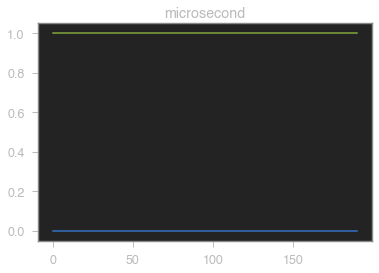

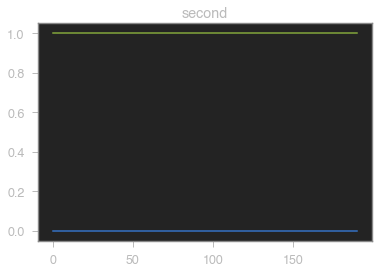

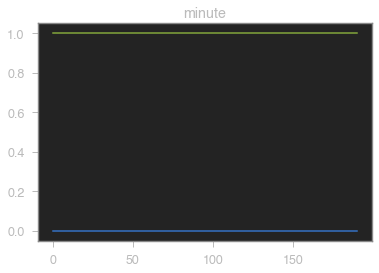

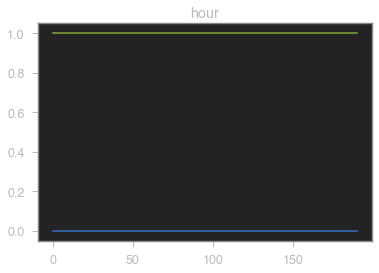

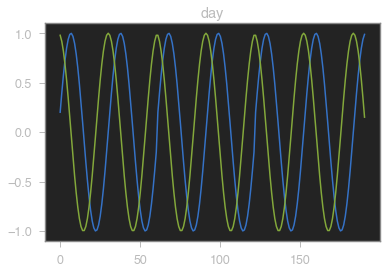

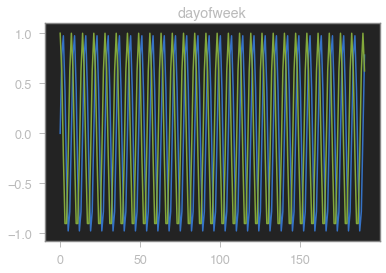

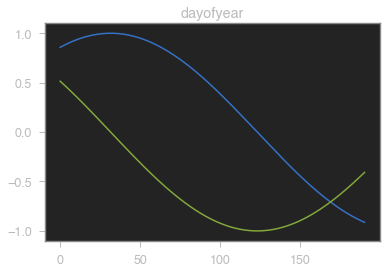

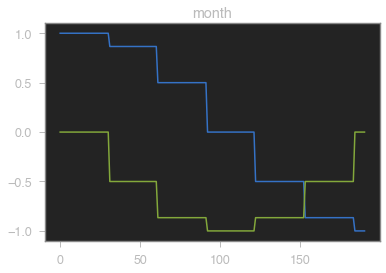

In [ ]:
for freq in ['microsecond', 'second', 'minute', 'hour', 'day', 'dayofweek', 'dayofyear', 'month']:
    tdf = pd.DataFrame(pd.date_range('2021-03-01', datetime.today()), columns=['date'])
    a,b = time_encoding(tdf.date, freq=freq)
    plt.plot(a)
    plt.plot(b)
    plt.title(freq)
    plt.show()

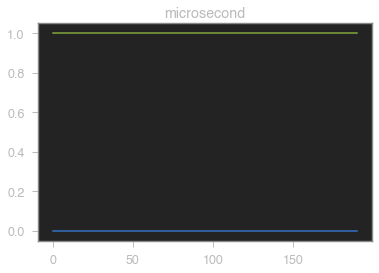

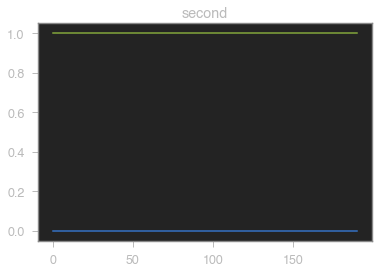

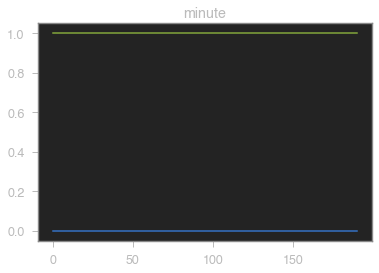

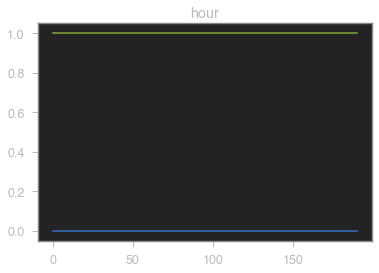

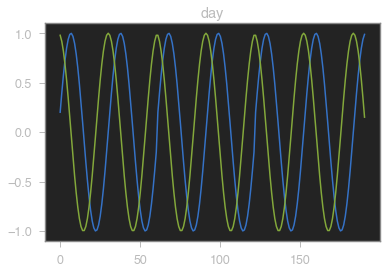

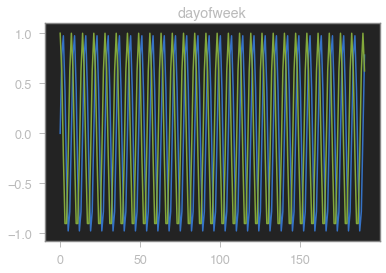

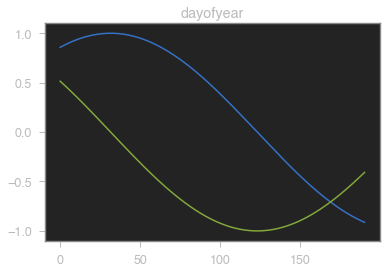

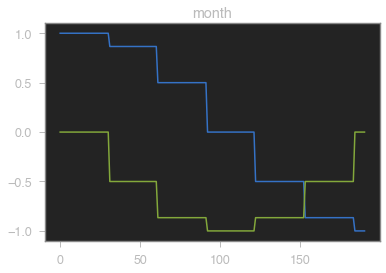

In [ ]:
for freq in ['microsecond', 'second', 'minute', 'hour', 'day', 'dayofweek', 'dayofyear', 'month']:
    dateindex = pd.date_range('2021-03-01', datetime.today())
    a,b = time_encoding(dateindex, freq=freq)
    plt.plot(a)
    plt.plot(b)
    plt.title(freq)
    plt.show()

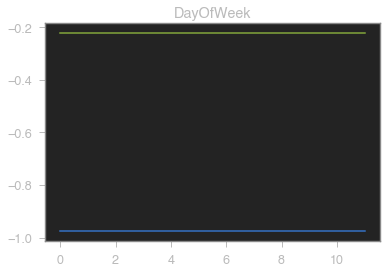

date  id  feature1  feature2   dow_sin   dow_cos
0  2021-05-01 00:00:00   0  0.187155  0.915019 -0.974928 -0.222521
1  2021-05-01 04:00:00   0  0.893723  0.046392 -0.974928 -0.222521
2  2021-05-01 08:00:00   0  0.875432  0.307387 -0.974928 -0.222521
3  2021-05-01 12:00:00   0  0.279109  0.808700 -0.974928 -0.222521
4  2021-05-01 16:00:00   0  0.609979  0.669742 -0.974928 -0.222521
5  2021-05-01 20:00:00   0  0.433989  0.253607 -0.974928 -0.222521
6  2021-05-01 00:00:00   1  0.476216  0.445574 -0.974928 -0.222521
7  2021-05-01 04:00:00   1  0.904921  0.871320 -0.974928 -0.222521
8  2021-05-01 08:00:00   1  0.608331  0.438078 -0.974928 -0.222521
9  2021-05-01 12:00:00   1  0.106761  0.411253 -0.974928 -0.222521
10 2021-05-01 16:00:00   1  0.185332  0.918347 -0.974928 -0.222521
11 2021-05-01 20:00:00   1  0.742461  0.608243 -0.974928 -0.222521

In [ ]:
dow_sin, dow_cos = time_encoding(date_df['date'], 'dayofweek')
plt.plot(dow_sin)
plt.plot(dow_cos)
plt.title('DayOfWeek')
plt.show()
date_df['dow_sin'] = dow_sin
date_df['dow_cos'] = dow_cos
date_df

In [ ]:
# export

def forward_gaps(o, nan_to_num=0, normalize=True):
    """Number of sequence steps since previous real value along the last dimension of 3D arrays or tensors"""

    b,c,s=o.shape
    if isinstance(o, torch.Tensor):
        idx = torch.where(o==o, torch.arange(s, device=o.device), 0)
        idx = torch.cummax(idx, axis=-1).values
        gaps = 1 + (torch.arange(s, device=o.device).reshape(1,1,-1).repeat(b, c, 1) - idx).float()
        mask = torch.isnan(o[torch.arange(b, device=o.device)[:,None, None], torch.arange(c, device=o.device)[None, :, None], idx])
    elif isinstance(o, np.ndarray):
        idx = np.where(o==o, np.arange(s), 0)
        idx = np.maximum.accumulate(idx,axis=-1)
        gaps = 1 + (np.arange(s).reshape(1,1,-1).repeat(b, 0).repeat(c, 1) - idx).astype(float)
        mask = np.isnan(o[np.arange(b)[:,None, None], np.arange(c)[None, :, None], idx])
    gaps[mask] = nan_to_num
    if normalize:
        gaps[gaps > 0] = gaps[gaps > 0] / s
    return gaps


def backward_gaps(o, nan_to_num=0, normalize=True):
    """Number of sequence steps to next real value along the last dimension of 3D arrays or tensors"""

    if isinstance(o, torch.Tensor): o = torch_flip(o, -1)
    elif isinstance(o, np.ndarray): o = o[..., ::-1]
    gaps = forward_gaps(o, nan_to_num=nan_to_num, normalize=normalize)
    if isinstance(o, torch.Tensor): gaps = torch_flip(gaps, -1)
    elif isinstance(o, np.ndarray): gaps = gaps[..., ::-1]
    return gaps


def nearest_gaps(o, nan_to_num=0, normalize=True):
    """Number of sequence steps to nearest real value along the last dimension of 3D arrays or tensors"""

    forward = forward_gaps(o, nan_to_num=np.nan, normalize=normalize)
    backward = backward_gaps(o, nan_to_num=np.nan, normalize=normalize)
    if isinstance(o, torch.Tensor):
        gaps = torch.fmin(forward, backward)
        gaps[torch.isnan(gaps)] = nan_to_num
        return gaps
    elif isinstance(o, np.ndarray):
        gaps = np.fmin(forward, backward)
        gaps[np.isnan(gaps)] = nan_to_num
        return gaps


def get_gaps(o : Tensor, nan_to_num : int = 0, forward : bool = True, backward : bool = True, 
             nearest : bool = True, normalize : bool = True):
    """Number of sequence steps from previous, to next and/or to nearest real value along the 
    last dimension of 3D arrays or tensors"""
    
    _gaps = []
    if forward or nearest:  
        fwd = forward_gaps(o, nan_to_num=np.nan, normalize=normalize)
        if forward: 
            _gaps.append(fwd)
    if backward or nearest: 
        bwd = backward_gaps(o, nan_to_num=np.nan, normalize=normalize)
        if backward: 
            _gaps.append(bwd)
    if nearest:
        if isinstance(o, torch.Tensor): 
            nst = torch.fmin(fwd, bwd)
        elif isinstance(o, np.ndarray): 
            nst = np.fmin(fwd, bwd)
        _gaps.append(nst)
    if isinstance(o, torch.Tensor): 
        gaps = torch.cat(_gaps, 1)
        gaps[torch.isnan(gaps)] = nan_to_num
    elif isinstance(o, np.ndarray):
        gaps = np.concatenate(_gaps, 1)
        gaps[np.isnan(gaps)] = nan_to_num
    return gaps

In [ ]:
t = torch.rand(1, 2, 8)
arr = t.numpy()
t[t <.6] = np.nan
test_ge(nearest_gaps(t).min().item(), 0)
test_ge(nearest_gaps(arr).min(), 0)
test_le(nearest_gaps(t).min().item(), 1)
test_le(nearest_gaps(arr).min(), 1)
test_eq(torch.isnan(forward_gaps(t)).sum(), 0)
test_eq(np.isnan(forward_gaps(arr)).sum(), 0)
ag = get_gaps(t)
test_eq(ag.shape, (1,6,8))
test_eq(torch.isnan(ag).sum(), 0)

In [ ]:
# export

def add_delta_timestamp_cols(df, cols=None, groupby=None, forward=True, backward=True, nearest=True, nan_to_num=0, normalize=True):
    if cols is None: cols = df.columns
    elif not is_listy(cols): cols = [cols]
    if forward or nearest:
        if groupby:
            forward_time_gaps = df[cols].groupby(df[groupby]).apply(lambda x: forward_gaps(x.values.transpose(1,0)[None], nan_to_num=np.nan, normalize=normalize))
            forward_time_gaps = np.concatenate(forward_time_gaps, -1)[0].transpose(1,0)
        else:
            forward_time_gaps = forward_gaps(df[cols].values.transpose(1,0)[None], nan_to_num=np.nan, normalize=normalize)[0].transpose(1,0)
        if forward : 
            df[[f'{col}_dt_fwd' for col in cols]] = forward_time_gaps
            df[[f'{col}_dt_fwd' for col in cols]] = df[[f'{col}_dt_fwd' for col in cols]].fillna(nan_to_num)
    if backward or nearest:
        if groupby:
            backward_time_gaps = df[cols].groupby(df[groupby]).apply(lambda x: backward_gaps(x.values.transpose(1,0)[None], nan_to_num=np.nan, normalize=normalize))
            backward_time_gaps = np.concatenate(backward_time_gaps, -1)[0].transpose(1,0)
        else:
            backward_time_gaps = backward_gaps(df[cols].values.transpose(1,0)[None], nan_to_num=np.nan, normalize=normalize)[0].transpose(1,0)
        if backward: 
            df[[f'{col}_dt_bwd' for col in cols]] = backward_time_gaps
            df[[f'{col}_dt_bwd' for col in cols]] = df[[f'{col}_dt_bwd' for col in cols]].fillna(nan_to_num)
    if nearest:
        df[[f'{col}_dt_nearest' for col in cols]] = np.fmin(forward_time_gaps, backward_time_gaps)
        df[[f'{col}_dt_nearest' for col in cols]] = df[[f'{col}_dt_nearest' for col in cols]].fillna(nan_to_num)
    return df


In [ ]:
# Add delta timestamp features for the no groups setting
dates = pd.date_range('2021-05-01', '2021-05-07').values
data = np.zeros((len(dates), 2))
data[:, 0] = dates
data[:, 1] = np.random.rand(len(dates))

cols = ['date', 'feature1']
date_df = pd.DataFrame(data, columns=cols).astype({'date': 'datetime64[ns]', 'feature1': float})
date_df.loc[[1,3,4],'feature1'] = np.nan

In [ ]:
# No groups

normalize = 1/len(dates)
expected_output_df = date_df.copy()
expected_output_df['feature1_dt_fwd'] = normalize
expected_output_df.loc[[1,3,4], 'feature1_dt_fwd'] = np.array([2,2,3]) * normalize

expected_output_df['feature1_dt_bwd'] = normalize
expected_output_df.loc[[1,3,4], 'feature1_dt_bwd'] = np.array([2,3,2]) * normalize

expected_output_df['feature1_dt_nearest'] = normalize
expected_output_df.loc[[1,3,4], 'feature1_dt_nearest'] =np.array([2,2,2]) * normalize

display(expected_output_df)
output_df = add_delta_timestamp_cols(date_df, cols='feature1')
test_eq(expected_output_df, output_df)

date  feature1  feature1_dt_fwd  feature1_dt_bwd  feature1_dt_nearest
0 2021-05-01  0.719650         0.142857         0.142857             0.142857
1 2021-05-02       NaN         0.285714         0.285714             0.285714
2 2021-05-03  0.542207         0.142857         0.142857             0.142857
3 2021-05-04       NaN         0.285714         0.428571             0.285714
4 2021-05-05       NaN         0.428571         0.285714             0.285714
5 2021-05-06  0.584756         0.142857         0.142857             0.142857
6 2021-05-07  0.058022         0.142857         0.142857             0.142857

In [ ]:
# Add delta timestamp features within a group
dates = pd.date_range('2021-05-01', '2021-05-07').values
dates = np.concatenate((dates, dates))
data = np.zeros((len(dates), 3))
data[:, 0] = dates
data[:, 1] = np.array([0]*(len(dates)//2)+[1]*(len(dates)//2))
data[:, 2] = np.random.rand(len(dates))

cols = ['date', 'id', 'feature1']
date_df = pd.DataFrame(data, columns=cols).astype({'date': 'datetime64[ns]', 'id': int, 'feature1': float})
date_df.loc[[1,3,4,8,9,11],'feature1'] = np.nan

In [ ]:
# groupby='id'

normalize = 2/len(dates)
expected_output_df = date_df.copy()
expected_output_df['feature1_dt_fwd'] = normalize
expected_output_df.loc[[1,3,4,8,9,11], 'feature1_dt_fwd'] = np.array([2,2,3,2,3,2]) * normalize

expected_output_df['feature1_dt_bwd'] = normalize
expected_output_df.loc[[1,3,4,8,9,11], 'feature1_dt_bwd'] = np.array([2,3,2,3,2,2]) * normalize

expected_output_df['feature1_dt_nearest'] = normalize
expected_output_df.loc[[1,3,4,8,9,11], 'feature1_dt_nearest'] =np.array([2,2,2,2,2,2]) * normalize

display(expected_output_df)
output_df = add_delta_timestamp_cols(date_df, cols='feature1', groupby='id')
test_eq(expected_output_df, output_df)

date  id  feature1  feature1_dt_fwd  feature1_dt_bwd  \
0  2021-05-01   0  0.204839         0.142857         0.142857   
1  2021-05-02   0       NaN         0.285714         0.285714   
2  2021-05-03   0  0.219687         0.142857         0.142857   
3  2021-05-04   0       NaN         0.285714         0.428571   
4  2021-05-05   0       NaN         0.428571         0.285714   
5  2021-05-06   0  0.847503         0.142857         0.142857   
6  2021-05-07   0  0.422250         0.142857         0.142857   
7  2021-05-01   1  0.420169         0.142857         0.142857   
8  2021-05-02   1       NaN         0.285714         0.428571   
9  2021-05-03   1       NaN         0.428571         0.285714   
10 2021-05-04   1  0.485123         0.142857         0.142857   
11 2021-05-05   1       NaN         0.285714         0.285714   
12 2021-05-06   1  0.232230         0.142857         0.142857   
13 2021-05-07   1  0.744660         0.142857         0.142857   

    feature1_dt_nearest  
0              0.142857  
1              0.285714  
2              0.142857  
3              0.285714  
4              0.285714  
5              0.142857  
6              0.142857  
7              0.142857  
8              0.285714  
9              0.285714  
10             0.142857  
11             0.285714  
12             0.142857  
13             0.142857

In [ ]:
# export
# # SlidingWindow vectorization is based on "Fast and Robust Sliding Window Vectorization with NumPy" by Syafiq Kamarul Azman
# # https://towardsdatascience.com/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5

def SlidingWindow(window_len:int, stride:Union[None, int]=1, start:int=0, pad_remainder:bool=False, padding_value:float=np.nan, add_padding_feature:bool=True,
                  get_x:Union[None, int, list]=None, get_y:Union[None, int, list]=None, y_func:Optional[callable]=None, copy:bool=False,
                  horizon:Union[int, list]=1, seq_first:bool=True, sort_by:Optional[list]=None, ascending:bool=True, check_leakage:bool=True):

    """
    Applies a sliding window to a 1d or 2d input (np.ndarray, torch.Tensor or pd.DataFrame)
    Args:
        window_len          = length of lookback window
        stride              = n datapoints the window is moved ahead along the sequence. Default: 1. If None, stride=window_len (no overlap)
        start               = determines the step where the first window is applied: 0 (default), a given step (int), or random within the 1st stride (None).
        pad_remainder       = allows to pad remainder subsequences when the sliding window is applied and get_y == [] (unlabeled data).
        padding_value       = value (float) that will be used for padding. Default: np.nan
        add_padding_feature = add an additional feature indicating whether each timestep is padded (1) or not (0).
        horizon             = number of future datapoints to predict:
                            * 0 for last step in each sub-window.
                            * n > 0 for a range of n future steps (1 to n).
                            * n < 0 for a range of n past steps (-n + 1 to 0).
                            * list : for those exact timesteps.
        get_x               = indices of columns that contain the independent variable (xs). If None, all data will be used as x.
        get_y               = indices of columns that contain the target (ys). If None, all data will be used as y.
                            [] means no y data is created (unlabeled data).
        y_func              = function to calculate the ys based on the get_y col/s and each y sub-window. y_func must be a function applied to axis=1!
        copy                = copy the original object to avoid changes in it.
        seq_first           = True if input shape (seq_len, n_vars), False if input shape (n_vars, seq_len)
        sort_by             = column/s used for sorting the array in ascending order
        ascending           = used in sorting
        check_leakage       = checks if there's leakage in the output between X and y
    Input:
        You can use np.ndarray, pd.DataFrame or torch.Tensor as input
        shape: (seq_len, ) or (seq_len, n_vars) if seq_first=True else (n_vars, seq_len)
    """

    if horizon == 0: horizon_rng = np.array([0])
    elif is_listy(horizon): horizon_rng = np.array(horizon)
    elif isinstance(horizon, Integral): horizon_rng = np.arange(1, horizon + 1) if horizon > 0 else np.arange(horizon + 1, 1)
    min_horizon = min(horizon_rng)
    max_horizon = max(horizon_rng)
    _get_x = slice(None) if get_x is None else get_x.tolist() if isinstance(get_x, pd.core.indexes.base.Index) else [get_x] if not is_listy(get_x) else get_x
    _get_y = slice(None) if get_y is None else get_y.tolist() if isinstance(get_y, pd.core.indexes.base.Index) else [get_y] if not is_listy(get_y) else get_y
    if min_horizon <= 0 and y_func is None and get_y != [] and check_leakage:
        assert get_x is not None and  get_y is not None and len([y for y in _get_y if y in _get_x]) == 0,  \
        'you need to change either horizon, get_x, get_y or use a y_func to avoid leakage'
    if stride == 0 or stride is None:
        stride = window_len

    def _inner(o):
        if copy: 
            if isinstance(o, torch.Tensor):  o = o.clone()
            else: o = o.copy()
        if not seq_first: o = o.T
        if isinstance(o, pd.DataFrame):
            if sort_by is not None: o.sort_values(by=sort_by, axis=0, ascending=ascending, inplace=True, ignore_index=True)
            X = o.loc[:, _get_x].values if get_x is None or not isinstance(_get_x[0], Integral) else o.iloc[:, _get_x].values
            if get_y != []: y = o.loc[:, _get_y].values if get_y is None or not isinstance(_get_y[0], Integral) else o.iloc[:, _get_y].values
        else:
            if isinstance(o, torch.Tensor): o = o.numpy()
            if o.ndim < 2: o = o[:, None]
            X = o[:, _get_x]
            if get_y != []: y = o[:, _get_y]
        seq_len = len(X)
        if get_y != []:
            X_max_time = seq_len - start - window_len - max_horizon - pad_remainder
        else:
            X_max_time = seq_len - start - window_len - pad_remainder
        if pad_remainder:
            if add_padding_feature:
                X = np.concatenate([X, np.zeros((X.shape[0], 1))], axis=1)
            X_max_time = X_max_time - X_max_time % stride + stride
            if window_len + start + X_max_time - len(X) >= 0:
                _X = np.empty((window_len + start + X_max_time - len(X), *X.shape[1:]))
                _X[:] = padding_value
                if add_padding_feature:
                    _X[:, -1] = 1
                X = np.concatenate((X, _X))
        elif X_max_time < 0: return None, None
        X_sub_windows = (start +
                         np.expand_dims(np.arange(window_len), 0) + # window len
                         np.expand_dims(np.arange(X_max_time + 1, step=stride), 0).T
                        ) # # subwindows
        X = np.transpose(X[X_sub_windows], (0, 2, 1))
        if get_y != [] and y is not None:
            y_start = start + window_len - 1
            y_max_time = seq_len - y_start - max_horizon - pad_remainder
            div = 0
            if pad_remainder:
                div = y_max_time % stride
                y_max_time = y_max_time - y_max_time % stride + stride
                if window_len + start + y_max_time - len(y) >= 0:
                    _y = np.empty((window_len + start + y_max_time - len(y), *y.shape[1:]))
                    _y[:] = padding_value
                    y = np.concatenate((y, _y))
            y_sub_windows = (y_start +
                             np.expand_dims(horizon_rng, 0) + # horizon_rng
                             np.expand_dims(np.arange(y_max_time + div, step=stride), 0).T
                            ) # # subwindows
            y = y[y_sub_windows]
            if y_func is not None and len(y) > 0:
                y = y_func(y)
            if y.ndim >= 2:
                for d in np.arange(1, y.ndim)[::-1]:
                    if y.shape[d] == 1: y = np.squeeze(y, axis=d)
            if y.ndim == 3:
                y = y.transpose(0, 2, 1)
            return X, y
        else: return X, None
    return _inner

SlidingWindowSplitter = SlidingWindow

In [ ]:
wl = 5
stride = 5

t = np.repeat(np.arange(13).reshape(-1,1), 3, axis=-1)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=stride, pad_remainder=True, get_y=[])(t)
X

input shape: (13, 3)


array([[[ 0.,  1.,  2.,  3.,  4.],
        [ 0.,  1.,  2.,  3.,  4.],
        [ 0.,  1.,  2.,  3.,  4.],
        [ 0.,  0.,  0.,  0.,  0.]],

       [[ 5.,  6.,  7.,  8.,  9.],
        [ 5.,  6.,  7.,  8.,  9.],
        [ 5.,  6.,  7.,  8.,  9.],
        [ 0.,  0.,  0.,  0.,  0.]],

       [[10., 11., 12., nan, nan],
        [10., 11., 12., nan, nan],
        [10., 11., 12., nan, nan],
        [ 0.,  0.,  0.,  1.,  1.]]])

In [ ]:
wl = 5
t = np.arange(10)
print('input shape:', t.shape)
X, y = SlidingWindow(wl)(t)
test_eq(X.shape[1:], (1, wl))
itemify(X,)

input shape: (10,)


(#5) [(array([[0, 1, 2, 3, 4]]),),(array([[1, 2, 3, 4, 5]]),),(array([[2, 3, 4, 5, 6]]),),(array([[3, 4, 5, 6, 7]]),),(array([[4, 5, 6, 7, 8]]),)]

In [ ]:
wl = 5
h = 1

t = np.arange(10)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=1, horizon=h)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (10,)
[(array([[0, 1, 2, 3, 4]]), 5), (array([[1, 2, 3, 4, 5]]), 6), (array([[2, 3, 4, 5, 6]]), 7), (array([[3, 4, 5, 6, 7]]), 8), (array([[4, 5, 6, 7, 8]]), 9)]


In [ ]:
wl = 5
h = 2 # 2 or more

t = np.arange(10)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, horizon=h)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, (2, ))

input shape: (10,)
[(array([[0, 1, 2, 3, 4]]), array([5, 6])), (array([[1, 2, 3, 4, 5]]), array([6, 7])), (array([[2, 3, 4, 5, 6]]), array([7, 8])), (array([[3, 4, 5, 6, 7]]), array([8, 9]))]


In [ ]:
wl = 5
h = 2 # 2 or more

t = np.arange(10).reshape(1, -1)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=1, horizon=h, get_y=None, seq_first=False)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, (2, ))

input shape: (1, 10)
[(array([[0, 1, 2, 3, 4]]), array([5, 6])), (array([[1, 2, 3, 4, 5]]), array([6, 7])), (array([[2, 3, 4, 5, 6]]), array([7, 8])), (array([[3, 4, 5, 6, 7]]), array([8, 9]))]


In [ ]:
wl = 5
h = 2 # 2 or more

t = np.arange(10).reshape(1, -1)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=1, horizon=h, seq_first=False)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))

input shape: (1, 10)
[(array([[0, 1, 2, 3, 4]]), array([5, 6])), (array([[1, 2, 3, 4, 5]]), array([6, 7])), (array([[2, 3, 4, 5, 6]]), array([7, 8])), (array([[3, 4, 5, 6, 7]]), array([8, 9]))]


In [ ]:
wl = 5

t = np.arange(10).reshape(1, -1)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=3, horizon=1, get_y=None, seq_first=False)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (1, 10)
[(array([[0, 1, 2, 3, 4]]), 5), (array([[3, 4, 5, 6, 7]]), 8)]


In [ ]:
wl = 5
start = 3

t = np.arange(20)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=None, horizon=1, start=start)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (20,)
[(array([[3, 4, 5, 6, 7]]), 8), (array([[ 8,  9, 10, 11, 12]]), 13), (array([[13, 14, 15, 16, 17]]), 18)]


In [ ]:
wl = 5

t = np.arange(20)
print('input shape:', t.shape)
df = pd.DataFrame(t, columns=['var'])
display(df)
X, y = SlidingWindow(wl, stride=None, horizon=1, get_y=None)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (20,)


var
0     0
1     1
2     2
3     3
4     4
5     5
6     6
7     7
8     8
9     9
10   10
11   11
12   12
13   13
14   14
15   15
16   16
17   17
18   18
19   19

[(array([[0, 1, 2, 3, 4]]), 5), (array([[5, 6, 7, 8, 9]]), 10), (array([[10, 11, 12, 13, 14]]), 15)]


In [ ]:
wl = 5

t = np.arange(20)
print('input shape:', t.shape)
df = pd.DataFrame(t, columns=['var'])
display(df)
X, y = SlidingWindow(wl, stride=1, horizon=1, get_y=None)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (20,)


var
0     0
1     1
2     2
3     3
4     4
5     5
6     6
7     7
8     8
9     9
10   10
11   11
12   12
13   13
14   14
15   15
16   16
17   17
18   18
19   19

[(array([[0, 1, 2, 3, 4]]), 5), (array([[1, 2, 3, 4, 5]]), 6), (array([[2, 3, 4, 5, 6]]), 7), (array([[3, 4, 5, 6, 7]]), 8), (array([[4, 5, 6, 7, 8]]), 9), (array([[5, 6, 7, 8, 9]]), 10), (array([[ 6,  7,  8,  9, 10]]), 11), (array([[ 7,  8,  9, 10, 11]]), 12), (array([[ 8,  9, 10, 11, 12]]), 13), (array([[ 9, 10, 11, 12, 13]]), 14), (array([[10, 11, 12, 13, 14]]), 15), (array([[11, 12, 13, 14, 15]]), 16), (array([[12, 13, 14, 15, 16]]), 17), (array([[13, 14, 15, 16, 17]]), 18), (array([[14, 15, 16, 17, 18]]), 19)]


In [ ]:
wl = 5

t = np.arange(20)
print('input shape:', t.shape)
df = pd.DataFrame(t, columns=['var']).T
display(df)
X, y = SlidingWindow(wl, stride=None, horizon=1, get_y=None, seq_first=False)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (20,)


0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16  17  \
var   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17   

     18  19  
var  18  19

[(array([[0, 1, 2, 3, 4]]), 5), (array([[5, 6, 7, 8, 9]]), 10), (array([[10, 11, 12, 13, 14]]), 15)]


In [ ]:
wl = 5
n_vars = 3

t = (torch.stack(n_vars * [torch.arange(10)]).T * tensor([1, 10, 100]))
print('input shape:', t.shape)
df = pd.DataFrame(t, columns=[f'var_{i}' for i in range(n_vars)])
display(df)
X, y = SlidingWindow(wl, horizon=1)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (n_vars, wl))

input shape: torch.Size([10, 3])


var_0  var_1  var_2
0      0      0      0
1      1     10    100
2      2     20    200
3      3     30    300
4      4     40    400
5      5     50    500
6      6     60    600
7      7     70    700
8      8     80    800
9      9     90    900

[(array([[  0,   1,   2,   3,   4],
       [  0,  10,  20,  30,  40],
       [  0, 100, 200, 300, 400]]), array([  5,  50, 500])), (array([[  1,   2,   3,   4,   5],
       [ 10,  20,  30,  40,  50],
       [100, 200, 300, 400, 500]]), array([  6,  60, 600])), (array([[  2,   3,   4,   5,   6],
       [ 20,  30,  40,  50,  60],
       [200, 300, 400, 500, 600]]), array([  7,  70, 700])), (array([[  3,   4,   5,   6,   7],
       [ 30,  40,  50,  60,  70],
       [300, 400, 500, 600, 700]]), array([  8,  80, 800])), (array([[  4,   5,   6,   7,   8],
       [ 40,  50,  60,  70,  80],
       [400, 500, 600, 700, 800]]), array([  9,  90, 900]))]


In [ ]:
wl = 5
n_vars = 3

t = (torch.stack(n_vars * [torch.arange(10)]).T * tensor([1, 10, 100]))
print('input shape:', t.shape)
df = pd.DataFrame(t, columns=[f'var_{i}' for i in range(n_vars)])
display(df)
X, y = SlidingWindow(wl, horizon=1, get_y=0)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (n_vars, wl))

input shape: torch.Size([10, 3])


var_0  var_1  var_2
0      0      0      0
1      1     10    100
2      2     20    200
3      3     30    300
4      4     40    400
5      5     50    500
6      6     60    600
7      7     70    700
8      8     80    800
9      9     90    900

[(array([[  0,   1,   2,   3,   4],
       [  0,  10,  20,  30,  40],
       [  0, 100, 200, 300, 400]]), 5), (array([[  1,   2,   3,   4,   5],
       [ 10,  20,  30,  40,  50],
       [100, 200, 300, 400, 500]]), 6), (array([[  2,   3,   4,   5,   6],
       [ 20,  30,  40,  50,  60],
       [200, 300, 400, 500, 600]]), 7), (array([[  3,   4,   5,   6,   7],
       [ 30,  40,  50,  60,  70],
       [300, 400, 500, 600, 700]]), 8), (array([[  4,   5,   6,   7,   8],
       [ 40,  50,  60,  70,  80],
       [400, 500, 600, 700, 800]]), 9)]


In [ ]:
wl = 5
n_vars = 3

t = (torch.stack(n_vars * [torch.arange(10)]).T * tensor([1, 10, 100]))
print('input shape:', t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)]+['target']
df = pd.DataFrame(t, columns=columns)
display(df)
X, y = SlidingWindow(wl, horizon=1, get_x=columns[:-1], get_y='target')(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (n_vars-1, wl))
test_eq(items[0][1].shape, ())

input shape: torch.Size([10, 3])


var_0  var_1  target
0      0      0       0
1      1     10     100
2      2     20     200
3      3     30     300
4      4     40     400
5      5     50     500
6      6     60     600
7      7     70     700
8      8     80     800
9      9     90     900

[(array([[ 0,  1,  2,  3,  4],
       [ 0, 10, 20, 30, 40]]), 500), (array([[ 1,  2,  3,  4,  5],
       [10, 20, 30, 40, 50]]), 600), (array([[ 2,  3,  4,  5,  6],
       [20, 30, 40, 50, 60]]), 700), (array([[ 3,  4,  5,  6,  7],
       [30, 40, 50, 60, 70]]), 800), (array([[ 4,  5,  6,  7,  8],
       [40, 50, 60, 70, 80]]), 900)]


(1000, 3)


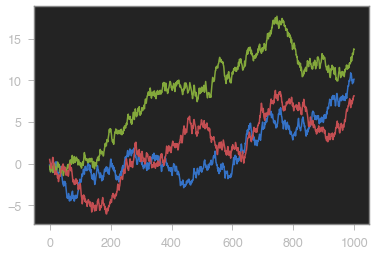

(200, 2, 5) (200,)


In [ ]:
n_vars = 3

t = (np.random.rand(1000, n_vars) - .5).cumsum(0)
print(t.shape)
plt.plot(t)
plt.show()
X, y = SlidingWindow(5, stride=None, horizon=0, get_x=[0,1], get_y=2)(t)
test_eq(X[0].shape, (n_vars-1, wl))
test_eq(y[0].shape, ())
print(X.shape, y.shape)

In [ ]:
wl = 5
n_vars = 3

t = (np.random.rand(100, n_vars) - .5).cumsum(0)
print(t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)]+['target']
df = pd.DataFrame(t, columns=columns)
display(df)
X, y = SlidingWindow(5, horizon=0, get_x=columns[:-1], get_y='target')(df)
test_eq(X[0].shape, (n_vars-1, wl))
test_eq(y[0].shape, ())
print(X.shape, y.shape)

(100, 3)


var_0     var_1    target
0  -0.263108  0.318372 -0.168169
1  -0.569344  0.757137 -0.249896
2  -0.847967  0.767506 -0.719240
3  -0.736115  1.093190 -0.718592
4  -0.773266  0.653933 -0.865676
..       ...       ...       ...
95 -1.143516 -3.051700  1.120605
96 -0.665312 -3.175680  0.839295
97 -0.736127 -3.172828  0.915273
98 -0.880771 -3.642267  1.214739
99 -0.590361 -3.277269  1.088406

[100 rows x 3 columns]

(96, 2, 5) (96,)


In [ ]:
seq_len = 100
n_vars = 5
t = (np.random.rand(seq_len, n_vars) - .5).cumsum(0)
print(t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)]+['target']
df = pd.DataFrame(t, columns=columns)
display(df)
X, y = SlidingWindow(5, stride=1, horizon=0, get_x=columns[:-1], get_y='target', seq_first=True)(df)
test_eq(X[0].shape, (n_vars-1, wl))
test_eq(y[0].shape, ())
print(X.shape, y.shape)

(100, 5)


var_0     var_1     var_2     var_3    target
0  -0.087362 -0.228351  0.353295  0.049053  0.073570
1  -0.110973 -0.450499  0.540081  0.017853 -0.318067
2  -0.335891 -0.408821  0.339223  0.010092  0.102354
3  -0.790259 -0.263256 -0.088932 -0.190370  0.156090
4  -0.570272 -0.525884  0.010257 -0.269107  0.323007
..       ...       ...       ...       ...       ...
95  0.219310  1.961916 -3.106080  2.829872  2.798448
96 -0.047061  2.058746 -3.371573  2.394822  2.540601
97 -0.466180  1.738243 -3.782462  1.910894  2.089843
98 -0.196545  1.884208 -4.207409  2.256528  2.427665
99  0.265858  2.025316 -4.443697  1.946179  2.565243

[100 rows x 5 columns]

(96, 4, 5) (96,)


In [ ]:
seq_len = 100
n_vars = 5

t = (np.random.rand(seq_len, n_vars) - .5).cumsum(0)
print(t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)] + ['target']
df = pd.DataFrame(t, columns=columns).T
display(df)
X, y = SlidingWindow(5, stride=1, horizon=0, get_x=columns[:-1], get_y='target', seq_first=False)(df)
test_eq(X[0].shape, (n_vars-1, wl))
test_eq(y[0].shape, ())
print(X.shape, y.shape)

(100, 5)


0         1         2         3         4         5         6   \
var_0   0.085133  0.289227  0.239836 -0.230778 -0.239381 -0.077155 -0.171094   
var_1  -0.300219 -0.565937 -0.420046  0.031626  0.176737  0.371990  0.832200   
var_2  -0.433622 -0.475693 -0.331148 -0.083345 -0.348196 -0.384470 -0.421814   
var_3   0.185585  0.646262  0.551937  0.725680  0.468214  0.316830  0.177557   
target -0.140530  0.309051  0.727219  0.539436  1.024594  0.733450  1.084314   

              7         8         9   ...        90        91        92  \
var_0  -0.144477 -0.227617  0.109566  ... -2.964280 -3.152730 -2.798921   
var_1   1.139053  0.737076  0.313102  ... -2.023989 -2.485722 -2.750858   
var_2  -0.906456 -0.586876 -0.536916  ... -2.090277 -2.138504 -1.703012   
var_3  -0.139236  0.303737  0.494407  ...  2.686487  2.534924  2.289137   
target  0.992031  1.204400  1.334017  ... -0.712291 -0.893413 -0.806492   

              93        94        95        96        97        98        99  
var_0  -2.570779 -2.912187 -2.586411 -2.630868 -2.337661 -2.817637 -2.580654  
var_1  -2.626104 -2.478323 -2.116411 -1.682181 -1.658040 -1.664202 -1.608218  
var_2  -1.391432 -1.360436 -1.346901 -1.050362 -0.590631 -0.814309 -1.289807  
var_3   1.794407  2.196374  2.449343  2.042740  2.140694  2.318361  1.839610  
target -1.259981 -1.031923 -0.786759 -1.278237 -1.523233 -1.789207 -1.454162  

[5 rows x 100 columns]

(96, 4, 5) (96,)


In [ ]:
seq_len = 100
n_vars = 5
t = (np.random.rand(seq_len, n_vars) - .5).cumsum(0)
print(t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)] + ['target']
df = pd.DataFrame(t, columns=columns).T
display(df)
X, y = SlidingWindow(5, stride=None, horizon=0, get_x=columns[:-1], get_y='target', seq_first=False)(df)
test_eq(X[0].shape, (n_vars-1, wl))
test_eq(y[0].shape, ())
print(X.shape, y.shape)

(100, 5)


0         1         2         3         4         5         6   \
var_0  -0.130780  0.220828  0.333106  0.509217  0.515558  0.462410  0.189965   
var_1  -0.422809 -0.178683  0.016694 -0.050124 -0.005638  0.321581  0.745094   
var_2  -0.332127 -0.343667  0.137487  0.065960 -0.128800 -0.305120 -0.087361   
var_3   0.437889  0.300949  0.633727  0.985994  1.209381  1.454029  1.815245   
target  0.218304  0.079053 -0.047952  0.239186 -0.012571 -0.157303 -0.147183   

              7         8         9   ...        90        91        92  \
var_0   0.454763  0.945452  1.445085  ...  4.181233  4.634471  4.435582   
var_1   0.883325  0.725989  0.795865  ...  3.538095  3.052028  2.991251   
var_2   0.390336  0.613462  1.090717  ...  1.642867  1.272612  1.727185   
var_3   1.745839  2.047191  2.332030  ...  4.164206  4.005892  4.211344   
target -0.230587  0.268900  0.582636  ... -3.287072 -3.400588 -3.031692   

              93        94        95        96        97        98        99  
var_0   4.566208  4.336585  3.904794  3.817224  3.749302  3.740377  4.067863  
var_1   3.320201  3.701190  3.573365  3.321622  3.217815  2.815580  2.509368  
var_2   1.825168  1.966283  1.941770  2.390918  2.827536  2.589797  2.633597  
var_3   4.579014  4.222763  3.869421  3.944900  4.140646  3.863244  4.289737  
target -2.628820 -3.103139 -2.625461 -2.648776 -2.910201 -3.160355 -3.399479  

[5 rows x 100 columns]

(20, 4, 5) (20,)


In [ ]:
seq_len = 100
n_vars = 5
t = (np.random.rand(seq_len, n_vars) - .5).cumsum(0)
print(t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)]+['target']
df = pd.DataFrame(t, columns=columns)
display(df)
X, y = SlidingWindow(5, stride=1, horizon=0, get_x=columns[:-1], get_y='target', seq_first=True)(df)
splits = TrainValidTestSplitter(valid_size=.2, shuffle=False)(y)
X.shape, y.shape, splits

(100, 5)


var_0     var_1     var_2     var_3    target
0  -0.090870  0.045297 -0.308626  0.114786  0.232408
1  -0.092036  0.062689  0.062992  0.160604 -0.053684
2   0.340734 -0.259629 -0.284480  0.060040 -0.216740
3  -0.148939 -0.480717 -0.237696  0.531836 -0.296103
4   0.039493 -0.175459  0.159641  0.592049 -0.298427
..       ...       ...       ...       ...       ...
95  2.958269 -6.089075 -1.635012 -0.488286 -0.909272
96  2.583401 -6.292410 -2.032778 -0.775338 -0.933870
97  2.187222 -6.789821 -2.009419 -0.395294 -1.288478
98  2.509323 -7.141650 -1.633110 -0.829584 -1.200866
99  2.392277 -6.929710 -1.170173 -1.326463 -1.354374

[100 rows x 5 columns]

((96, 4, 5),
 (96,),
 ((#77) [0,1,2,3,4,5,6,7,8,9...], (#19) [77,78,79,80,81,82,83,84,85,86...]))

In [ ]:
data = np.concatenate([np.linspace(0, 1, 11).reshape(-1,1).repeat(2, 1), np.arange(11).reshape(-1,1)], -1)
df_test = pd.DataFrame(data, columns=['col1', 'col2', 'target'])
df_test['target'] = df_test['target'].astype(int)
df_test

col1  col2  target
0    0.0   0.0       0
1    0.1   0.1       1
2    0.2   0.2       2
3    0.3   0.3       3
4    0.4   0.4       4
5    0.5   0.5       5
6    0.6   0.6       6
7    0.7   0.7       7
8    0.8   0.8       8
9    0.9   0.9       9
10   1.0   1.0      10

In [ ]:
def _y_func(o): return o[:, 0]

In [ ]:
for wl in np.arange(1, 20):
    x, y = SlidingWindow(wl, None, pad_remainder=True, get_x=['col1', 'col2'], get_y=['target'], horizon=-wl, y_func=_y_func)(df_test)
    test_eq(x.shape[0], math.ceil((len(df_test))/wl))
    test_eq(x.shape[0], y.shape[0])
    test_eq(x.shape[1], 3)
    test_eq(x.shape[2], wl)
    test_close(x[:, 0, 0]*10, y)

In [ ]:
for wl in np.arange(1, 20):
    x, y = SlidingWindow(wl, None, pad_remainder=True, get_x=['col1', 'col2'], get_y=['target'], horizon=-wl, y_func=None)(df_test)
    test_eq(x.shape[0], math.ceil((len(df_test))/ wl))
    test_eq(x.shape[0], y.shape[0])
    test_eq(x.shape[1], 3)
    test_eq(x.shape[2], wl)

In [ ]:
for wl in np.arange(1, len(df_test)+1):
    x, y = SlidingWindow(wl, None, pad_remainder=False, get_x=['col1', 'col2'], get_y=['target'], horizon=-wl, y_func=None)(df_test)
    test_eq(x.shape[0], len(df_test) // wl)
    test_eq(x.shape[0], y.shape[0])
    test_eq(x.shape[1], 2)
    test_eq(x.shape[2], wl)

In [ ]:
for wl in np.arange(1, 20):
    x, _ = SlidingWindow(wl, None, pad_remainder=True, get_x=['col1', 'col2'], get_y=[])(df_test)
    test_eq(x.shape[0], math.ceil((len(df_test))/wl))
    test_eq(x.shape[1], 3)
    test_eq(x.shape[2], wl)

In [ ]:
for wl in np.arange(2, len(df_test)):
    x, _ = SlidingWindow(wl, wl, pad_remainder=False, get_x=['col1', 'col2'], get_y=[])(df_test)
    test_eq(x.shape[0], len(df_test) // wl)
    test_eq(x.shape[1], 2)
    test_eq(x.shape[2], wl)

In [ ]:
#export
def SlidingWindowPanel(window_len:int, unique_id_cols:list, stride:Union[None, int]=1, start:int=0,
                       pad_remainder:bool=False, padding_value:float=np.nan, add_padding_feature:bool=True,
                       get_x:Union[None, int, list]=None,  get_y:Union[None, int, list]=None, y_func:Optional[callable]=None, copy:bool=False,
                       horizon:Union[int, list]=1, seq_first:bool=True, sort_by:Optional[list]=None, ascending:bool=True,
                       check_leakage:bool=True, return_key:bool=False, verbose:bool=True):

    """
    Applies a sliding window to a pd.DataFrame.

    Args:
        window_len          = length of lookback window
        unique_id_cols      = pd.DataFrame columns that will be used to identify a time series for each entity.
        stride              = n datapoints the window is moved ahead along the sequence. Default: 1. If None, stride=window_len (no overlap)
        start               = determines the step where the first window is applied: 0 (default), a given step (int), or random within the 1st stride (None).
        pad_remainder       = allows to pad remainder subsequences when the sliding window is applied and get_y == [] (unlabeled data).
        padding_value       = value (float) that will be used for padding. Default: np.nan
        add_padding_feature = add an additional feature indicating whether each timestep is padded (1) or not (0).
        horizon             = number of future datapoints to predict:
                            * 0 for last step in each sub-window.
                            * n > 0 for a range of n future steps (1 to n).
                            * n < 0 for a range of n past steps (-n + 1 to 0).
                            * list : for those exact timesteps.
        get_x               = indices of columns that contain the independent variable (xs). If None, all data will be used as x.
        get_y               = indices of columns that contain the target (ys). If None, all data will be used as y. [] means no y data is created (unlabeled data).
        y_func              = function to calculate the ys based on the get_y col/s and each y sub-window. y_func must be a function applied to axis=1!
        copy                = copy the original object to avoid changes in it.
        seq_first           = True if input shape (seq_len, n_vars), False if input shape (n_vars, seq_len)
        sort_by             = column/s used for sorting the array in ascending order
        ascending           = used in sorting
        check_leakage       = checks if there's leakage in the output between X and y
        return_key          = when True, the key corresponsing to unique_id_cols for each sample is returned
        verbose             = controls verbosity. True or 1 displays progress bar. 2 or more show records that cannot be created due to its length.


    Input:
        You can use np.ndarray, pd.DataFrame or torch.Tensor as input
        shape: (seq_len, ) or (seq_len, n_vars) if seq_first=True else (n_vars, seq_len)
    """

    if not is_listy(unique_id_cols): unique_id_cols = [unique_id_cols]
    if sort_by is not None and not  is_listy(sort_by): sort_by = [sort_by]
    sort_by = unique_id_cols + (sort_by if sort_by is not None else [])

    def _SlidingWindowPanel(o):

        if copy: 
            o = o.copy()
        o.sort_values(by=sort_by, axis=0, ascending=ascending, inplace=True, ignore_index=True)
        unique_id_values = o[unique_id_cols].drop_duplicates().values
        _x = []
        _y = []
        _key = []
        for v in progress_bar(unique_id_values, display=verbose, leave=False):
            x_v, y_v = SlidingWindow(window_len, stride=stride, start=start, pad_remainder=pad_remainder, padding_value=padding_value,
                                     add_padding_feature=add_padding_feature, get_x=get_x, get_y=get_y, y_func=y_func,
                                     horizon=horizon, seq_first=seq_first,
                                     check_leakage=check_leakage)(o[(o[unique_id_cols].values == v).sum(axis=1) == len(v)])
            if x_v is not None and len(x_v) > 0:
                _x.append(x_v)
                if return_key: _key.append([v.tolist()] * len(x_v))
                if y_v is not None and len(y_v) > 0: _y.append(y_v)
            elif verbose>=2:
                print(f'cannot use {unique_id_cols} = {v} due to not having enough records')

        X = np.concatenate(_x)
        if _y != []:
            y = np.concatenate(_y)
            for d in np.arange(1, y.ndim)[::-1]:
                if y.shape[d] == 1: y = np.squeeze(y, axis=d)
        else: y = None
        if return_key:
            key = np.concatenate(_key)
            if key.ndim == 2 and key.shape[-1] == 1: key = np.squeeze(key, -1)
            if return_key: return X, y, key
        else: return X, y

    return _SlidingWindowPanel

SlidingWindowPanelSplitter = SlidingWindowPanel

In [ ]:
samples = 100_000
wl = 5
n_vars = 10

t = (torch.stack(n_vars * [torch.arange(samples)]).T * tensor([10**i for i in range(n_vars)]))
df = pd.DataFrame(t, columns=[f'var_{i}' for i in range(n_vars)])
df['time'] = np.arange(len(t))
df['device'] = 0
df['target'] = np.random.randint(0, 2, len(df))
df2 = df.copy()
df3 = df.copy()
cols = ['var_0', 'var_1', 'var_2', 'device', 'target']
df2[cols] = df2[cols] + 1
df3[cols] = df3[cols] + 2
df2 = df2.loc[:3]
df['region'] = 'A'
df2['region'] = 'A'
df3['region'] = 'B'
df = df.append(df2).append(df3).reset_index(drop=True)
df['index'] = np.arange(len(df))
df = df.sample(frac=1).reset_index(drop=True)
display(df.head())
df.shape

var_0   var_1    var_2     var_3      var_4       var_5        var_6  \
0  41904  419040  4190400  41904000  419040000  4190400000  41904000000   
1  48517  485170  4851700  48517000  485170000  4851700000  48517000000   
2  72840  728382  7283802  72838000  728380000  7283800000  72838000000   
3  18591  185892  1858902  18589000  185890000  1858900000  18589000000   
4  41515  415132  4151302  41513000  415130000  4151300000  41513000000   

          var_7          var_8           var_9   time  device  target region  \
0  419040000000  4190400000000  41904000000000  41904       0       0      A   
1  485170000000  4851700000000  48517000000000  48517       0       1      A   
2  728380000000  7283800000000  72838000000000  72838       2       2      B   
3  185890000000  1858900000000  18589000000000  18589       2       2      B   
4  415130000000  4151300000000  41513000000000  41513       2       2      B   

    index  
0   41904  
1   48517  
2  172842  
3  118593  
4  141517

(200004, 15)

In [ ]:
X, y = SlidingWindowPanel(window_len=5, unique_id_cols=['device'], stride=1, start=0, get_x=df.columns[:n_vars], get_y=['target'], 
                          horizon=0, seq_first=True, sort_by=['time'], ascending=True, return_key=False)(df)
X.shape, y.shape

((199992, 10, 5), (199992,))

In [ ]:
X, y, key = SlidingWindowPanel(window_len=5, unique_id_cols=['device'], stride=1, start=0, get_x=df.columns[:n_vars], get_y=['target'], 
                               horizon=0, seq_first=True, sort_by=['time'], ascending=True, return_key=True)(df)
X.shape, y.shape, key.shape

((199992, 10, 5), (199992,), (199992,))

In [ ]:
X, y = SlidingWindowPanel(window_len=5, unique_id_cols=['device', 'region'], stride=1, start=0, get_x=df.columns[:n_vars], get_y=['target'], 
                          horizon=0, seq_first=True, sort_by=['time'], ascending=True)(df)
X.shape, y.shape

((199992, 10, 5), (199992,))

In [ ]:
# y_func must be a function applied to axis=1!
def y_max(o): return np.max(o, axis=1)

In [ ]:
X, y = SlidingWindowPanel(window_len=5, unique_id_cols=['device', 'region'], stride=1, start=0, get_x=df.columns[:n_vars], get_y=['target'], 
                          y_func=y_max, horizon=5, seq_first=True, sort_by=['time'], ascending=True)(df)
X.shape, y.shape

((199982, 10, 5), (199982,))

In [ ]:
# export

def identify_padding(float_mask, value=-1):
    """Identifies padded subsequences in a mask of type float
    
    This function identifies as padded subsequences those where all values == nan 
    from the end of the sequence (last dimension) across all channels, and sets
    those values to the selected value (default = -1)
    
    Args:
        mask: boolean or float mask
        value: scalar that will be used to identify padded subsequences 
    """
    padding = torch.argmax((torch.flip(float_mask.mean((1)) - 1, (-1,)) != 0).float(), -1)
    padded_idxs = torch.arange(len(float_mask))[padding != 0]
    if len(padded_idxs) > 0:
        padding = padding[padding != 0]
        for idx,pad in zip(padded_idxs, padding): float_mask[idx, :, -pad:] = value
    return float_mask

In [ ]:
wl = 5
stride = 5

t = np.repeat(np.arange(13).reshape(-1,1), 3, axis=-1)
print('input shape:', t.shape)
X, _ = SlidingWindow(wl, stride=stride, pad_remainder=True, get_y=[])(t)
X = tensor(X)
X[0, 1, -2:] = np.nan
X[1,..., :3] = np.nan
print(X)
identify_padding(torch.isnan(X).float())

input shape: (13, 3)
tensor([[[ 0.,  1.,  2.,  3.,  4.],
         [ 0.,  1.,  2., nan, nan],
         [ 0.,  1.,  2.,  3.,  4.],
         [ 0.,  0.,  0.,  0.,  0.]],

        [[nan, nan, nan,  8.,  9.],
         [nan, nan, nan,  8.,  9.],
         [nan, nan, nan,  8.,  9.],
         [nan, nan, nan,  0.,  0.]],

        [[10., 11., 12., nan, nan],
         [10., 11., 12., nan, nan],
         [10., 11., 12., nan, nan],
         [ 0.,  0.,  0.,  1.,  1.]]])


tensor([[[0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]],

        [[1., 1., 1., 0., 0.],
         [1., 1., 1., 0., 0.],
         [1., 1., 1., 0., 0.],
         [1., 1., 1., 0., 0.]],

        [[0., 0., 0., 1., 1.],
         [0., 0., 0., 1., 1.],
         [0., 0., 0., 1., 1.],
         [0., 0., 0., 0., 0.]]])

In [ ]:
#hide
out = create_scripts(); beep(out)

<IPython.core.display.Javascript object>

Converted 000_utils.ipynb.
Converted 000b_data.validation.ipynb.
Converted 000c_data.preparation.ipynb.
Converted 001_data.external.ipynb.
Converted 002_data.core.ipynb.
Converted 002b_data.unwindowed.ipynb.
Converted 002c_data.metadatasets.ipynb.
Converted 003_data.preprocessing.ipynb.
Converted 003b_data.transforms.ipynb.
Converted 003c_data.mixed_augmentation.ipynb.
Converted 003d_data.image.ipynb.
Converted 003e_data.features.ipynb.
Converted 005_data.tabular.ipynb.
Converted 006_data.mixed.ipynb.
Converted 050_losses.ipynb.
Converted 051_metrics.ipynb.
Converted 052_learner.ipynb.
Converted 052b_tslearner.ipynb.
Converted 053_optimizer.ipynb.
Converted 060_callback.core.ipynb.
Converted 061_callback.noisy_student.ipynb.
Converted 063_callback.MVP.ipynb.
Converted 064_callback.PredictionDynamics.ipynb.
Converted 100_models.layers.ipynb.
Converted 100b_models.utils.ipynb.
Converted 100c_models.explainability.ipynb.
Converted 101_models.ResNet.ipynb.
Converted 101b_models.ResNetPlus.